In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

{}

In [3]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d splcher/animefacedataset

animefacedataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import os
from zipfile import ZipFile
with ZipFile('animefacedataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')

In [5]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras import backend as K
import keras

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

Using TensorFlow backend.


In [0]:
def v_encoder():
    global K
    K.clear_session()
    
    encoder_input = Input(shape = (128,128,3), name = 'encoder_input')
    x = encoder_input
    
    chanDim = -1
    # encoder CNN
    x = Conv2D(32, (3,3), strides=2, padding="same", input_shape=image_dim)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(64, (3,3), strides=2, padding="same", input_shape=image_dim)(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3,3), strides=2, padding="same", input_shape=image_dim)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3,3), strides=2, padding="same", input_shape=image_dim)(x)
    x = Activation('relu')(x)
    
    shape_before_flattening = K.int_shape(x)[1:] 
    x = Flatten()(x)
    
    mean_mu = Dense(200, name = 'mu')(x)
    log_var = Dense(200, name = 'log_var')(x)

    def sampling(args):
        mean_mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon   
  
    encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])
    
    return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)

In [0]:
def decoder(shape_before_flattening):
    decoder_input = Input(shape = (200, ), name = 'decoder_input')
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)
    
    x = Conv2DTranspose(64, (3,3), strides = 2, padding = 'same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(64, (3,3), strides = 2, padding = 'same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(32, (3,3), strides = 2, padding = 'same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (3,3), strides = 2, padding = 'same')(x)
    x = Activation('sigmoid')(x)
    
    decoder_output = x
    
    return decoder_input, decoder_output, Model(decoder_input, decoder_output)

In [0]:
e = 250
lr = 0.001
bs = 256
image_dim = (128,128,3)

In [9]:
data = []
labels = []

print("Loading images....")
waifu_paths = list(paths.list_images("data"))

for waifu_path in waifu_paths:
    image = cv2.imread(waifu_path)
    image = cv2.resize(image, (image_dim[1], image_dim[0]))
    image = img_to_array(image)

    data.append(image)
print("Load completed")

Loading images....
Load completed


In [2]:
data = np.array(data) /255.0

In [11]:
encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, encoder = v_encoder()
encoder.summary()
decoder_input, decoder_output, decoder_ = decoder(shape_before_flattening)
decoder_.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   18496       leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [12]:
vae_input = encoder_input

vae_output = decoder_(encoder_output)

vae_model = Model(vae_input, vae_output)

vae_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   18496       leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [0]:
LOSS_FACTOR = 10000


def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

In [0]:
vae_model.compile(optimizer=keras.optimizers.Adam(lr=lr), loss = total_loss, metrics = [r_loss, kl_loss])

In [16]:
import gc

def fit_callback():
    gc.collect()

H = vae_model.fit(data, data,bs, e, validation_data=(data,data), callbacks = fit_callback())

Train on 63565 samples, validate on 63565 samples
Epoch 1/250
63565/63565 [==============================] - 51s 798us/step - loss: 288.3810 - r_loss: 0.0238 - kl_loss: 50.1108 - val_loss: 281.3364 - val_r_loss: 0.0230 - val_kl_loss: 51.1978
Epoch 2/250
63565/63565 [==============================] - 51s 796us/step - loss: 277.5179 - r_loss: 0.0225 - kl_loss: 52.2920 - val_loss: 273.7602 - val_r_loss: 0.0220 - val_kl_loss: 53.7936
Epoch 3/250
63565/63565 [==============================] - 51s 796us/step - loss: 272.2688 - r_loss: 0.0218 - kl_loss: 53.9666 - val_loss: 270.3529 - val_r_loss: 0.0217 - val_kl_loss: 53.3118
Epoch 4/250
63565/63565 [==============================] - 51s 797us/step - loss: 268.9355 - r_loss: 0.0214 - kl_loss: 55.2058 - val_loss: 267.0908 - val_r_loss: 0.0209 - val_kl_loss: 57.6698
Epoch 5/250
63565/63565 [==============================] - 51s 797us/step - loss: 264.0317 - r_loss: 0.0207 - kl_loss: 57.0735 - val_loss: 261.5643 - val_r_loss: 0.0206 - val_kl_loss

In [0]:
%matplotlib inline

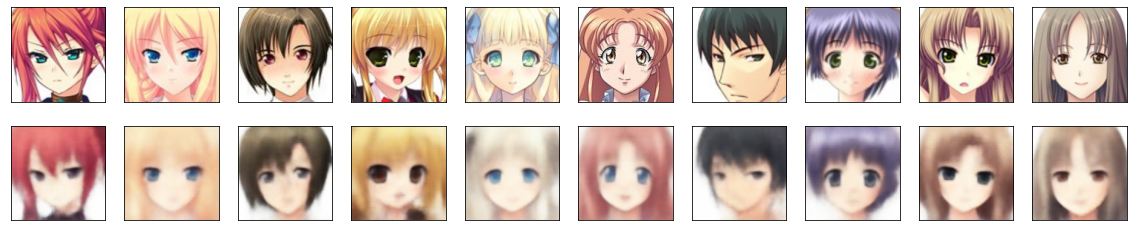

In [18]:
predicted = vae_model.predict(data[:10].reshape(-1, 128, 128, 3))

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([data[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

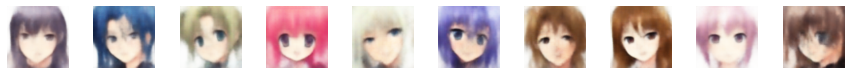

In [19]:
reconst_images = decoder_.predict(np.random.normal(0,1,size=(10,200)))

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(10):
  img = reconst_images[i].squeeze()
  sub = fig.add_subplot(2, 10, i+1)
  sub.axis('off')        
  sub.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [0]:
vae_model.save("vae_model.h5")